<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
Supplementary code for the <a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a> book by <a href="https://sebastianraschka.com">Sebastian Raschka</a><br>
<br>Code repository: <a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/cover-small.webp" width="100px"></a>
</td>
</tr>
</table>


# Appendix E: Parameter-efficient Finetuning with LoRA

In [1]:
from importlib.metadata import version

pkgs = ["matplotlib",
        "numpy",
        "tiktoken",
        "torch",
        "tensorflow", # For OpenAI's pretrained weights
        "pandas"      # Dataset loading
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.10.6
numpy version: 2.0.2
tiktoken version: 0.11.0
torch version: 2.8.0
tensorflow version: 2.20.0
pandas version: 2.3.2


## E.1 Introduction to LoRA

- No code in this section
- Low-rank adaptation (LoRA) is a machine learning technique that modifies a pretrained model to better suit a specific, often smaller, dataset by adjusting only a small, low-rank subset of the model's parameters
- This approach is important because it allows for efficient finetuning of large models on task-specific data, significantly reducing the computational cost and time required for finetuning

- Suppose we have a large weight matrix $W$ for a given layer
- During backpropagation, we learn a $\Delta W$ matrix, which contains information on how much we want to update the original weights to minimize the loss function during training
- In regular training and finetuning, the weight update is defined as follows:

$$W_{\text{updated}} = W + \Delta W$$

- The LoRA method proposed by [Hu et al.](https://arxiv.org/abs/2106.09685) offers a more efficient alternative to computing the weight updates $\Delta W$ by learning an approximation of it, $\Delta W \approx AB$.
- In other words, in LoRA, we have the following, where $A$ and $B$ are two small weight matrices:

$$W_{\text{updated}} = W + AB$$

- The figure below illustrates these formulas for full finetuning and LoRA side by side

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/appendix-e_compressed/lora-1.webp" width="500px">

- If you paid close attention, the full finetuning and LoRA depictions in the figure above look slightly different from the formulas I have shown earlier
- That's due to the distributive law of matrix multiplication: we don't have to add the weights with the updated weights but can keep them separate
- For instance, if $x$ is the input data, then we can write the following for regular finetuning:

$$x (W+\Delta W) = x W + x \Delta W$$

- Similarly, we can write the following for LoRA:

$$x (W+A B) = x W + x A B$$

- The fact that we can keep the LoRA weight matrices separate makes LoRA especially attractive
- In practice, this means that we don't have to modify the weights of the pretrained model at all, as we can apply the LoRA matrices on the fly
- After setting up the dataset and loading the model, we will implement LoRA in the code to make these concepts less abstract

## E.2 Preparing the dataset

- This section repeats the code from chapter 6 to load and prepare the dataset
- Instead of repeating this code, one could open and run the chapter 6 notebook and then insert the LoRA code from section E.4 there
- (The LoRA code was originally the last section of chapter 6 but was moved to the appendix due to the length of chapter 6)
- In a similar fashion, we could also apply LoRA to the models in chapter 7 for instruction finetuning

In [2]:
import urllib
from pathlib import Path
import pandas as pd
from previous_chapters import (
    download_and_unzip_spam_data,
    create_balanced_dataset,
    random_split
)
# If the `previous_chapters.py` file is not available locally,
# you can import it from the `llms-from-scratch` PyPI package.
# For details, see: https://github.com/rasbt/LLMs-from-scratch/tree/main/pkg
# E.g.,
# from llms_from_scratch.ch06 import (
#     download_and_unzip_spam_data,
#     create_balanced_dataset,
#     random_split
# )



# url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
# zip_path = "sms_spam_collection.zip"
# extracted_path = "sms_spam_collection"
# data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

# try:
#     download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)
# except (urllib.error.HTTPError, urllib.error.URLError, TimeoutError) as e:
#     print(f"Primary URL failed: {e}. Trying backup URL...")
#     url = "https://f001.backblazeb2.com/file/LLMs-from-scratch/sms%2Bspam%2Bcollection.zip"
#     download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)


In [3]:
data_file_path = '../../ch06/01_main-chapter-code/sms_spam_collection/SMSSpamCollection.tsv'

df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
balanced_df = create_balanced_dataset(df)
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

In [4]:
train_df.head()

,Label,Text
0,0,Dude how do you like the buff wind.
1,0,Tessy..pls do me a favor. Pls convey my birthd...
2,1,Reminder: You have not downloaded the content ...
3,1,Got what it takes 2 take part in the WRC Rally...
4,1,"Shop till u Drop, IS IT YOU, either 10K, 5K, £..."


In [5]:
test_df.head()

,Label,Text
1194,1,85233 FREE>Ringtone!Reply REAL
1195,1,Ur cash-balance is currently 500 pounds - to m...
1196,1,"Thanks for your ringtone order, reference numb..."
1197,0,We live in the next &lt;#&gt; mins
1198,1,1st wk FREE! Gr8 tones str8 2 u each wk. Txt N...


In [6]:
import torch
import tiktoken
from previous_chapters import SpamDataset


tokenizer = tiktoken.get_encoding("gpt2")
train_dataset = SpamDataset("train.csv", max_length=None, tokenizer=tokenizer)
val_dataset = SpamDataset("validation.csv", max_length=train_dataset.max_length, tokenizer=tokenizer)
test_dataset = SpamDataset("test.csv", max_length=train_dataset.max_length, tokenizer=tokenizer)

In [7]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

- As a verification step, we iterate through the data loaders and check that the batches contain 8 training examples each, where each training example consists of 120 tokens

In [8]:
print("Train loader:")
for input_batch, target_batch in train_loader:
    pass

print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

Train loader:
Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])


- Lastly, let's print the total number of batches in each dataset

In [9]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


## E.3 Initializing the model

- This section repeats the code from chapter 6 to load and prepare the model

In [10]:
from gpt_download import download_and_load_gpt2
from previous_chapters import GPTModel, load_weights_into_gpt
# Alternatively:
# from llms_from_scratch.ch04 import GPTModel
# from llms_from_scratch.ch05 import load_weights_into_gpt



CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])


model_dir = '../../ch05/01_main-chapter-code/gpt2'  # 'gpt2'
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir=model_dir)  #"gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

2025-10-06 15:05:06.103658: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


File already exists and is up-to-date: ../../ch05/01_main-chapter-code/gpt2/124M/checkpoint
File already exists and is up-to-date: ../../ch05/01_main-chapter-code/gpt2/124M/encoder.json
File already exists and is up-to-date: ../../ch05/01_main-chapter-code/gpt2/124M/hparams.json
File already exists and is up-to-date: ../../ch05/01_main-chapter-code/gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: ../../ch05/01_main-chapter-code/gpt2/124M/model.ckpt.index
File already exists and is up-to-date: ../../ch05/01_main-chapter-code/gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: ../../ch05/01_main-chapter-code/gpt2/124M/vocab.bpe


2025-10-06 15:05:11.709203: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 154389504 exceeds 10% of free system memory.


- To ensure that the model was loaded corrected, let's double-check that it generates coherent text

In [11]:
from previous_chapters import (
    generate_text_simple,
    text_to_token_ids,
    token_ids_to_text
)


text_1 = "Every effort moves you"

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


- Then, we prepare the model for classification finetuning similar to chapter 6, where we replace the output layer

In [12]:
torch.manual_seed(123)

num_classes = 2
model.out_head = torch.nn.Linear(in_features=768, out_features=num_classes)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Note:
# Uncommenting the following lines will allow the code to run on Apple Silicon chips, if applicable,
# which is approximately 1.2x faster than on an Apple CPU (as measured on an M3 MacBook Air).
# However, the resulting loss values may be slightly different.

#if torch.cuda.is_available():
#    device = torch.device("cuda")
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")
#else:
#    device = torch.device("cpu")
#
# print(f"Using {device} device.")

model.to(device);  # no assignment model = model.to(device) necessary for nn.Module classes

- Lastly, let's calculate the initial classification accuracy of the non-finetuned model (we expect this to be around 50%, which means that the model is not able to distinguish between spam and non-spam messages yet reliably)

In [14]:
from previous_chapters import calc_accuracy_loader
# Alternatively:
# from llms_from_scratch.ch06 import calc_accuracy_loader



torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


## E.4 Parameter-efficient finetuning with LoRA

- We begin by initializing a LoRALayer that creates the matrices $A$ and $B$, along with the `alpha` scaling hyperparameter and the `rank` ($r$) hyperparameters
- This layer can accept an input and compute the corresponding output, as illustrated in the figure below

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/appendix-e_compressed/lora-2.webp" width="200px">

In code, this LoRA layer depicted in the figure above looks like as follows

In [15]:
import math

class LoRALayer(torch.nn.Module):
    def __init__(self, in_dim, out_dim, rank, alpha):
        super().__init__()
        self.A = torch.nn.Parameter(torch.empty(in_dim, rank))
        torch.nn.init.kaiming_uniform_(self.A, a=math.sqrt(5))  # similar to standard weight initialization
        self.B = torch.nn.Parameter(torch.zeros(rank, out_dim))
        self.alpha = alpha
        self.rank = rank

    def forward(self, x):
        # Note: The original chapter didn't include the scaling by self.rank
        # This scaling is not necessary, but it's more canonical and convenient
        # as this lets us compare runs across different ranks without retuning learning rates
        x = (self.alpha / self.rank) * (x @ self.A @ self.B)
        return x

- In the code above, `rank` is a hyperparameter that controls the inner dimension of the matrices $A$ and $B$
- In other words, this parameter controls the number of additional parameters introduced by LoRA and is a key factor in determining the balance between model adaptability and parameter efficiency
- The second hyperparameter, `alpha`, is a scaling hyperparameter applied to the output of the low-rank adaptation
- It essentially controls the extent to which the adapted layer's output is allowed to influence the original output of the layer being adapted
- This can be seen as a way to regulate the impact of the low-rank adaptation on the layer's output
- So far, the `LoRALayer` class we implemented above allows us to transform the layer inputs $x$
- However, in LoRA, we are usually interested in replacing existing `Linear` layers so that the weight update is applied to the existing pretrained weights, as shown in the figure below

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/appendix-e_compressed/lora-3.webp" width="200px">

- To incorporate the original `Linear` layer weights as shown in the figure above, we implement a `LinearWithLoRA` layer below that uses the previously implemented LoRALayer and can be used to replace existing `Linear` layers in a neural network, for example, the self-attention module or feed forward modules in an LLM

In [16]:
class LinearWithLoRA(torch.nn.Module):
    def __init__(self, linear, rank, alpha):
        super().__init__()
        self.linear = linear
        self.lora = LoRALayer(
            linear.in_features, linear.out_features, rank, alpha
        )

    def forward(self, x):
        return self.linear(x) + self.lora(x)

- Note that since we initialize the weight matrix $B$ (`self.B` in `LoRALayer`) with zero values in the LoRA layer, the matrix multiplication between $A$ and $B$ results in a matrix consisting of 0's and doesn't affect the original weights (since adding 0 to the original weights does not modify them)

- To try LoRA on the GPT model we defined earlier, we define a `replace_linear_with_lora` function to replace all `Linear` layers in the model with the new `LinearWithLoRA` layers

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/appendix-e_compressed/lora-4.webp" width="400px">

In [ ]:
for name, module in model.named_children():
   print(module.named_modules)


<bound method Module.named_modules of Embedding(50257, 768)>
<bound method Module.named_modules of Embedding(1024, 768)>
<bound method Module.named_modules of Dropout(p=0.0, inplace=False)>
<bound method Module.named_modules of Sequential(
  (0): TransformerBlock(
    (att): MultiHeadAttention(
      (W_query): LinearWithLoRA(
        (linear): Linear(in_features=768, out_features=768, bias=True)
        (lora): LoRALayer()
      )
      (W_key): LinearWithLoRA(
        (linear): Linear(in_features=768, out_features=768, bias=True)
        (lora): LoRALayer()
      )
      (W_value): LinearWithLoRA(
        (linear): Linear(in_features=768, out_features=768, bias=True)
        (lora): LoRALayer()
      )
      (out_proj): LinearWithLoRA(
        (linear): Linear(in_features=768, out_features=768, bias=True)
        (lora): LoRALayer()
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (ff): FeedForward(
      (layers): Sequential(
        (0): LinearWithLoRA(
          (l

In [18]:
def replace_linear_with_lora(model, rank, alpha):
    for name, module in model.named_children():
        if isinstance(module, torch.nn.Linear):
            # Replace the Linear layer with LinearWithLoRA
            setattr(model, name, LinearWithLoRA(module, rank, alpha))
        else:
            # Recursively apply the same function to child modules
            replace_linear_with_lora(module, rank, alpha)

- We then freeze the original model parameter and use the `replace_linear_with_lora` to replace the said `Linear` layers using the code below
- This will replace the `Linear` layers in the LLM with `LinearWithLoRA` layers

In [19]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters before: {total_params:,}")

for param in model.parameters():
    param.requires_grad = False

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters after: {total_params:,}")

Total trainable parameters before: 124,441,346
Total trainable parameters after: 0


In [20]:
replace_linear_with_lora(model, rank=16, alpha=16)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable LoRA parameters: {total_params:,}")

Total trainable LoRA parameters: 2,666,528


- As we can see, we reduced the number of trainable parameters by almost 50x when using LoRA
- Let's now double-check whether the layers have been modified as intended by printing the model architecture

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (W_key): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (W_value): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (out_proj): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): LinearWithLoRA(
            (linear): Linear(in_features=768, out_featu

- Based on the model architecture above, we can see that the model now contains our new `LinearWithLoRA` layers
- Also, since we initialized matrix $B$ with 0's, we expect the initial model performance to be unchanged compared to before

In [22]:
torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


- Let's now get to the interesting part and finetune the model by reusing the training function from chapter 6
- The training takes about 15 minutes on a M3 MacBook Air laptop computer and less than half a minute on a V100 or A100 GPU

In [23]:
import time
from previous_chapters import train_classifier_simple
# Alternatively:
# from llms_from_scratch.ch06 import train_classifier_simple


start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=8e-4, weight_decay=0.1)

num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 3.820, Val loss 3.462
Ep 1 (Step 000050): Train loss 0.346, Val loss 0.325
Ep 1 (Step 000100): Train loss 0.063, Val loss 0.144
Training accuracy: 100.00% | Validation accuracy: 92.50%
Ep 2 (Step 000150): Train loss 0.054, Val loss 0.045
Ep 2 (Step 000200): Train loss 0.058, Val loss 0.122
Ep 2 (Step 000250): Train loss 0.041, Val loss 0.199
Training accuracy: 100.00% | Validation accuracy: 95.00%
Ep 3 (Step 000300): Train loss 0.020, Val loss 0.153
Ep 3 (Step 000350): Train loss 0.018, Val loss 0.191
Training accuracy: 100.00% | Validation accuracy: 95.00%
Ep 4 (Step 000400): Train loss 0.019, Val loss 0.088
Ep 4 (Step 000450): Train loss 0.001, Val loss 0.045
Ep 4 (Step 000500): Train loss 0.001, Val loss 0.141
Training accuracy: 100.00% | Validation accuracy: 95.00%
Ep 5 (Step 000550): Train loss 0.007, Val loss 0.106
Ep 5 (Step 000600): Train loss 0.000, Val loss 0.314
Training accuracy: 100.00% | Validation accuracy: 92.50%
Training completed in 31.1

- Finally, let's evaluate the model

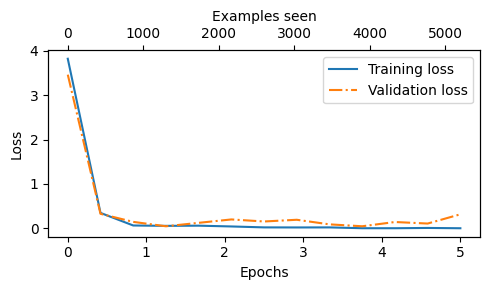

In [24]:
from previous_chapters import plot_values
# Alternatively:
# from llms_from_scratch.ch06 import plot_values

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses, label="loss")

- Note that we previously calculated the accuracy values on 5 batches only via the `eval_iter=5` setting; below, we calculate the accuracies on the full dataset

In [25]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 98.37%
Validation accuracy: 95.97%
Test accuracy: 95.33%


- As we can see based on the relatively high accuracy values above, the LoRA finetuning was successful